Import packages

In [30]:
import geopandas as gpd
import pandas as pd
import numpy as np
import cenpy as cen
import math
import matplotlib.pyplot as plt
%matplotlib inline

## Explore my data

In [31]:
# Import my census tract/census data shapefile
census_geodata = gpd.read_file(r'C:\Users\zstat\Documents\RecurseCenter\EJ-analysis-map\Data\Created\NJ_cen_data.shp')

In [32]:
# Import NJ public water system data
pws_geodata = gpd.read_file(r'C:\Users\zstat\Documents\RecurseCenter\EJ-analysis-map\Data\NJDEP\PWS\New_Jersey__Public_Community_Water_Purveyor_Service_Areas.shp')

In [33]:
# Explore NJ public water system data
pws_geodata.info()
pws_geodata.crs

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 574 entries, 0 to 573
Data columns (total 14 columns):
OBJECTID      574 non-null int64
PI_ID         574 non-null int64
PWID          574 non-null object
SYS_NAME      574 non-null object
AREA_TYPE     574 non-null object
PWID_URL      574 non-null object
AGENCY_URL    507 non-null object
NOTES         502 non-null object
USER_LAST_    574 non-null object
TMSP_LAST_    574 non-null object
GLOBALID      574 non-null object
SHAPE_Leng    574 non-null float64
SHAPE_Area    574 non-null float64
geometry      574 non-null object
dtypes: float64(2), int64(2), object(10)
memory usage: 62.9+ KB


{'init': 'epsg:3424'}

In [34]:
# Re-project census tract data to NJ public water system projection
census_geodata = census_geodata.to_crs({'init': 'epsg:3424'})
census_geodata.crs

{'init': 'epsg:3424'}

In [35]:
# Add a column for the tract area that will be used later in the analysis
census_geodata['Tract_area'] = census_geodata.geometry.area

In [36]:
# Check new column
census_geodata.info()
census_geodata['Tract_area'].iloc[0]

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 20 columns):
AREALAND      2001 non-null int64
AREAWATER     2001 non-null int64
BASENAME      2001 non-null object
CENTLAT       2001 non-null object
CENTLON       2001 non-null object
GEOID         2001 non-null object
STGEOMETRY    2001 non-null float64
STGEOMET_1    2001 non-null float64
TRACT         2001 non-null object
total_pop     2001 non-null int64
white_pop     2001 non-null int64
pov_pop       2001 non-null int64
state         2001 non-null object
county        2001 non-null object
tract_1       2001 non-null object
POC_pop       2001 non-null int64
perc_POC      2001 non-null float64
perc_pov      2001 non-null float64
geometry      2001 non-null object
Tract_area    2001 non-null float64
dtypes: float64(5), int64(6), object(9)
memory usage: 312.7+ KB


48065305.14989849

In [37]:
# Compare the extents
print(census_geodata.total_bounds)
print(pws_geodata.total_bounds)

[193684.7715927   33447.02647309 659397.88822466 919474.4764048 ]
[194285.63785167  34945.75480994 652962.48919693 903736.57037444]


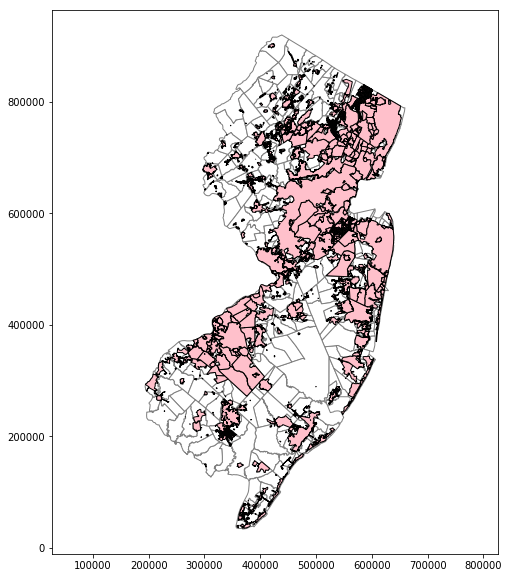

In [38]:
# Plot both data sets
fig, ax = plt.subplots(figsize = (8, 10))
census_geodata.plot(ax=ax,
                    facecolor='white',
                    edgecolor='grey')
pws_geodata.plot(ax=ax,
                facecolor='pink',
                edgecolor='black')

# Turn off the axis
plt.axis('equal')
#ax.set_axis_off()
plt.show()


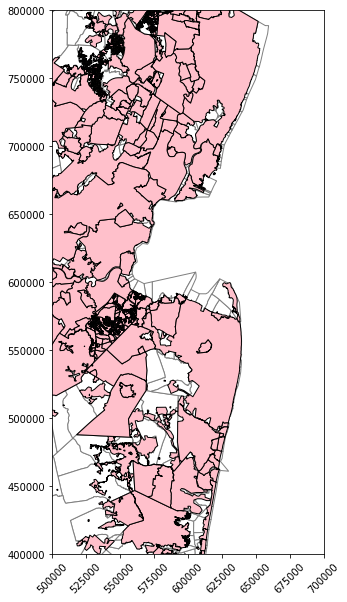

In [39]:
#Plot both data sets and zoom in
fig, ax = plt.subplots(figsize = (8, 10))
census_geodata.plot(ax=ax,
                    facecolor='white',
                    edgecolor='grey')
pws_geodata.plot(ax=ax,
                facecolor='pink',
                edgecolor='black')

# Zoom in
ax.set(xlim=[500000, 700000], ylim=[400000,800000])

# Edit tick marks
ax.tick_params(axis='x', rotation=45)

plt.show()

## Predict the population within the water systems using areal weighting

In [40]:
print(census_geodata.crs, pws_geodata.crs)

{'init': 'epsg:3424'} {'init': 'epsg:3424'}


In [41]:
intersect = gpd.overlay(census_geodata, pws_geodata, how="intersection")

In [42]:
with pd.option_context('display.max_columns', None):
    display(pd.DataFrame(intersect.head(5)))

,AREALAND,AREAWATER,BASENAME,CENTLAT,CENTLON,GEOID,STGEOMETRY,STGEOMET_1,TRACT,total_pop,white_pop,pov_pop,state,county,tract_1,POC_pop,perc_POC,perc_pov,Tract_area,OBJECTID,PI_ID,PWID,SYS_NAME,AREA_TYPE,PWID_URL,AGENCY_URL,NOTES,USER_LAST_,TMSP_LAST_,GLOBALID,SHAPE_Leng,SHAPE_Area,geometry
1,2045098,2421092,7137,+40.0591547,-074.0846083,34029713700,7.632871e+06,18250.432033,713700,2569,2285,58,34,029,713700,284,11.054885,2.257688,4.806531e+07,318,89537,NJ1506001,BrickTwp MUA,S,http://www.nj.gov/cgi-bin/dep/swap/swapdata2.p...,http://www.brickmua.com/,None,eapalins,2009-05-12T00:00:00.000Z,{1F5F9395-43F5-4B4B-9F9C-8CF0CEB04CA0},201242.699919,6.748567e+08,"POLYGON ((601709.842132538 445161.681821719, 6..."
5,6947272,4268255,7138,+40.0428715,-074.0768848,34029713800,1.915864e+07,21673.434238,713800,3395,2874,241,34,029,713800,521,15.346097,7.098675,1.207022e+08,318,89537,NJ1506001,BrickTwp MUA,S,http://www.nj.gov/cgi-bin/dep/swap/swapdata2.p...,http://www.brickmua.com/,None,eapalins,2009-05-12T00:00:00.000Z,{1F5F9395-43F5-4B4B-9F9C-8CF0CEB04CA0},201242.699919,6.748567e+08,"POLYGON ((600930.6280628778 440132.7762078509,..."
753,2736521,26291,7133,+40.0862702,-074.1319864,34029713300,4.725465e+06,9259.991462,713300,3989,3782,340,34,029,713300,207,5.189270,8.523439,2.973327e+07,318,89537,NJ1506001,BrickTwp MUA,S,http://www.nj.gov/cgi-bin/dep/swap/swapdata2.p...,http://www.brickmua.com/,None,eapalins,2009-05-12T00:00:00.000Z,{1F5F9395-43F5-4B4B-9F9C-8CF0CEB04CA0},201242.699919,6.748567e+08,"POLYGON ((591621.6779719713 458737.1300715086,..."
756,3333438,556314,7135,+40.0657483,-074.1168234,34029713500,6.649003e+06,12510.286739,713500,3016,2880,150,34,029,713500,136,4.509284,4.973475,4.186155e+07,318,89537,NJ1506001,BrickTwp MUA,S,http://www.nj.gov/cgi-bin/dep/swap/swapdata2.p...,http://www.brickmua.com/,None,eapalins,2009-05-12T00:00:00.000Z,{1F5F9395-43F5-4B4B-9F9C-8CF0CEB04CA0},201242.699919,6.748567e+08,"POLYGON ((594473.025762534 448865.1688220116, ..."
1197,3624454,21777,7132.03,+40.1014907,-074.1201887,34029713203,6.239224e+06,10555.798595,713203,4808,3743,341,34,029,713203,1065,22.150582,7.092346,3.924071e+07,318,89537,NJ1506001,BrickTwp MUA,S,http://www.nj.gov/cgi-bin/dep/swap/swapdata2.p...,http://www.brickmua.com/,None,eapalins,2009-05-12T00:00:00.000Z,{1F5F9395-43F5-4B4B-9F9C-8CF0CEB04CA0},201242.699919,6.748567e+08,"POLYGON ((592994.6612521429 460347.5989503982,..."


In [43]:
intersect.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4086 entries, 1 to 6186
Data columns (total 33 columns):
AREALAND      4086 non-null int64
AREAWATER     4086 non-null int64
BASENAME      4086 non-null object
CENTLAT       4086 non-null object
CENTLON       4086 non-null object
GEOID         4086 non-null object
STGEOMETRY    4086 non-null float64
STGEOMET_1    4086 non-null float64
TRACT         4086 non-null object
total_pop     4086 non-null int64
white_pop     4086 non-null int64
pov_pop       4086 non-null int64
state         4086 non-null object
county        4086 non-null object
tract_1       4086 non-null object
POC_pop       4086 non-null int64
perc_POC      4086 non-null float64
perc_pov      4086 non-null float64
Tract_area    4086 non-null float64
OBJECTID      4086 non-null int64
PI_ID         4086 non-null int64
PWID          4086 non-null object
SYS_NAME      4086 non-null object
AREA_TYPE     4086 non-null object
PWID_URL      4086 non-null object
AGENCY_URL   

In [44]:
# Remove unecessary rows and change some names to be more clear
intersect = intersect.drop(columns=['AREALAND','AREAWATER','state','county','tract_1','CENTLAT','CENTLON','STGEOMETRY', 'STGEOMET_1','PWID_URL', 'AGENCY_URL','USER_LAST_','TMSP_LAST_','SHAPE_Leng'])
intersect = intersect.rename(columns={'SHAPE_Area': 'PWS_Area'})

In [45]:
intersect.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4086 entries, 1 to 6186
Data columns (total 19 columns):
BASENAME      4086 non-null object
GEOID         4086 non-null object
TRACT         4086 non-null object
total_pop     4086 non-null int64
white_pop     4086 non-null int64
pov_pop       4086 non-null int64
POC_pop       4086 non-null int64
perc_POC      4086 non-null float64
perc_pov      4086 non-null float64
Tract_area    4086 non-null float64
OBJECTID      4086 non-null int64
PI_ID         4086 non-null int64
PWID          4086 non-null object
SYS_NAME      4086 non-null object
AREA_TYPE     4086 non-null object
NOTES         3686 non-null object
GLOBALID      4086 non-null object
PWS_Area      4086 non-null float64
geometry      4086 non-null object
dtypes: float64(4), int64(6), object(9)
memory usage: 638.4+ KB


In [46]:
intersect['Intersect_area'] = intersect.geometry.area

In [47]:
intersect['Intersect_total_pop'] = (intersect['Intersect_area'] / intersect['Tract_area']) * intersect['total_pop']
intersect['Intersect_pov_pop'] = (intersect['Intersect_area'] / intersect['Tract_area']) * intersect['pov_pop']
intersect['Intersect_POC_pop'] = (intersect['Intersect_area'] / intersect['Tract_area']) * intersect['POC_pop']

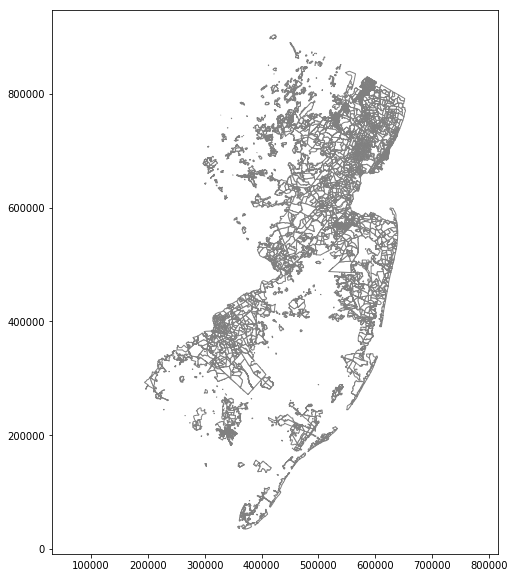

In [48]:
# Plot Intersection
fig, ax = plt.subplots(figsize = (8, 10))
intersect.plot(ax=ax,
                    facecolor='white',
                    edgecolor='grey')


plt.axis('equal')
plt.show()

In [49]:
with pd.option_context('display.max_columns', None):
    display(intersect.sort_values(by=['GEOID']).head(5))

,BASENAME,GEOID,TRACT,total_pop,white_pop,pov_pop,POC_pop,perc_POC,perc_pov,Tract_area,OBJECTID,PI_ID,PWID,SYS_NAME,AREA_TYPE,NOTES,GLOBALID,PWS_Area,geometry,Intersect_area,Intersect_total_pop,Intersect_pov_pop,Intersect_POC_pop
2653,1,34001000100,000100,2190,583,792,1607,73.378995,36.164384,2.336706e+07,190,86650,NJ0102001,Atlantic City MUA,S,update new muni (201512 no change)(spoke with ...,{F8BF80B8-A07C-4BBE-A848-4183B1E3D075},1.502353e+08,(POLYGON ((501606.1497712695 187592.7253140094...,1.935045e+07,1813.556620,655.861572,1330.769629
2652,1,34001000100,000100,2190,583,792,1607,73.378995,36.164384,2.336706e+07,218,87667,NJ0122001,Ventnor City Water & Sewer Utility,S,update new muni 201112,{2746B211-F9D1-454E-8570-5D9EA7F4AD36},3.489182e+07,"POLYGON ((499883.2686220873 189391.9324253091,...",1.252220e+01,0.001174,0.000424,0.000861
2700,2,34001000200,000200,3352,1500,910,1852,55.250597,27.147971,1.284547e+07,218,87667,NJ0122001,Ventnor City Water & Sewer Utility,S,update new muni 201112,{2746B211-F9D1-454E-8570-5D9EA7F4AD36},3.489182e+07,(POLYGON ((501651.4292761609 186568.6292352287...,2.608066e+00,0.000681,0.000185,0.000376
2701,2,34001000200,000200,3352,1500,910,1852,55.250597,27.147971,1.284547e+07,190,86650,NJ0102001,Atlantic City MUA,S,update new muni (201512 no change)(spoke with ...,{F8BF80B8-A07C-4BBE-A848-4183B1E3D075},1.502353e+08,(POLYGON ((503195.1889079546 188748.4580454084...,5.430222e+06,1417.005225,384.688173,782.903842
2703,3,34001000300,000300,4134,377,1431,3757,90.880503,34.615385,4.422940e+06,190,86650,NJ0102001,Atlantic City MUA,S,update new muni (201512 no change)(spoke with ...,{F8BF80B8-A07C-4BBE-A848-4183B1E3D075},1.502353e+08,(POLYGON ((504754.7017528858 190030.6253678025...,4.061760e+06,3796.414756,1314.143570,3450.200832


In [52]:
# Select the columns I will retain
PWS_dissolve = intersect[['PWID','SYS_NAME','geometry','Intersect_area','Intersect_total_pop','Intersect_pov_pop','Intersect_POC_pop']]

In [53]:
PWS_dissolve['geometry'] = PWS_dissolve.buffer(0.01)

C:\Users\zstat\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [54]:
# Dissolve and summarize the quantitative columns by sum
PWS_agg = PWS_dissolve.dissolve(by='PWID',aggfunc='sum')

In [55]:
#Reset the index so the PWID is a column
PWS_agg = PWS_agg.reset_index()

In [56]:
PWS_agg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 574 entries, 0 to 573
Data columns (total 6 columns):
PWID                   574 non-null object
geometry               574 non-null object
Intersect_area         574 non-null float64
Intersect_total_pop    574 non-null float64
Intersect_pov_pop      574 non-null float64
Intersect_POC_pop      574 non-null float64
dtypes: float64(4), object(2)
memory usage: 27.0+ KB


In [57]:
with pd.option_context('display.max_columns', None):
    display(PWS_agg.head(5))

,PWID,geometry,Intersect_area,Intersect_total_pop,Intersect_pov_pop,Intersect_POC_pop
0,NJ0102001,(POLYGON ((497860.4602464174 196288.4292888343...,1.502353e+08,28422.774066,11778.005065,24513.210106
1,NJ0103001,"POLYGON ((515752.6858546621 202163.5393238475,...",7.377988e+07,2626.482642,305.691512,368.488183
2,NJ0104003,"POLYGON ((358984.6680578727 246157.0587467105,...",1.045117e+08,1975.369923,211.360809,678.052804
3,NJ0105001,"POLYGON ((382017.3487498079 264208.1571022005,...",4.075818e+05,2.633283,0.355535,0.650936
4,NJ0105002,"POLYGON ((383871.0728139255 228984.5435644306,...",8.502179e+05,5.493043,0.741649,1.357856


In [58]:
# Add in columns for percentage people below the poverty line and percentage 
# people of color
PWS_agg['perc_pov'] = PWS_agg['Intersect_pov_pop'] / PWS_agg['Intersect_total_pop']
PWS_agg['perc_POC'] = PWS_agg['Intersect_POC_pop'] / PWS_agg['Intersect_total_pop']

In [59]:
# Get the NJ state boundary from the TIGER API to plot with the data (see Census
# Jupyter Notebook for more exploration of this process)
con = cen.base.Connection('ACSDT5Y2017')
con.set_mapservice('tigerWMS_ACS2017')

#Get state boundary data
NJ_boundary = con.mapservice.query(layer=82, where='STATE=34',pkg='geopandas')

In [60]:
# The current way the crs is stored is a dictionary using latestwkid, which causes errors during export. I converted the crs 
# dictionary into one readable by geopandas, but it is not transforming the data in any way. 
NJ_boundary.crs = {'init': 'epsg:3857'}

In [61]:
#Transform to same projection as PWS data
NJ_boundary=NJ_boundary.to_crs(PWS_agg.crs)

C:\Users\zstat\Anaconda2\envs\py36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


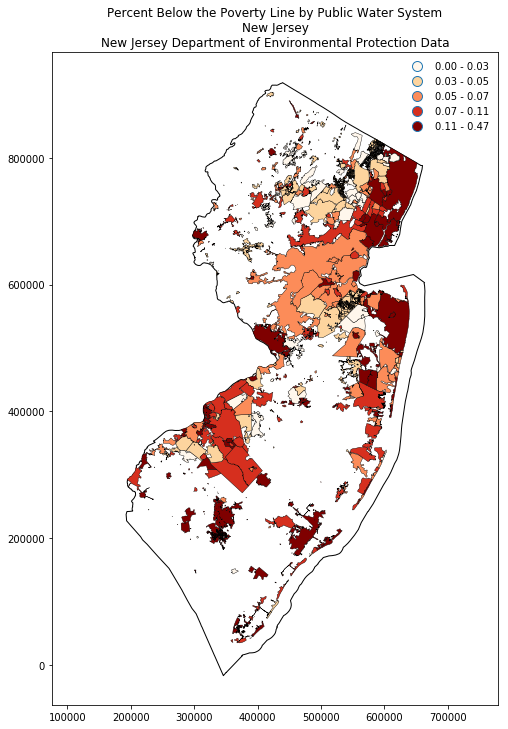

In [62]:
# Plotting percent below the poverty line by public water system
# Plot the data
fig, ax = plt.subplots(figsize = (8,12))
NJ_boundary.plot(ax=ax,
                edgecolor='black',
                facecolor='white')
PWS_agg.plot(ax = ax,
             column='perc_pov', 
             scheme='QUANTILES',
             k=5,cmap='OrRd',
             edgecolor='black',
             linewidth=0.4, 
             legend=True)

# Geopandas source codes as the legend as a second axis
legend = ax.get_legend()
legend.get_frame().set_linewidth(0.0)
#legend.set(title = 'Percentage Below the Poverty Line')

# Add title to map
ax.set(title = "Percent Below the Poverty Line by Public Water System\n" +
       "New Jersey\n"+
       "New Jersey Department of Environmental Protection Data")

# Turn off the axis
plt.axis('equal')
#ax.set_axis_off()
plt.show()

C:\Users\zstat\Anaconda2\envs\py36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(168373.93850331433, 686814.023928478, -62623.08861899875, 966241.0271202169)

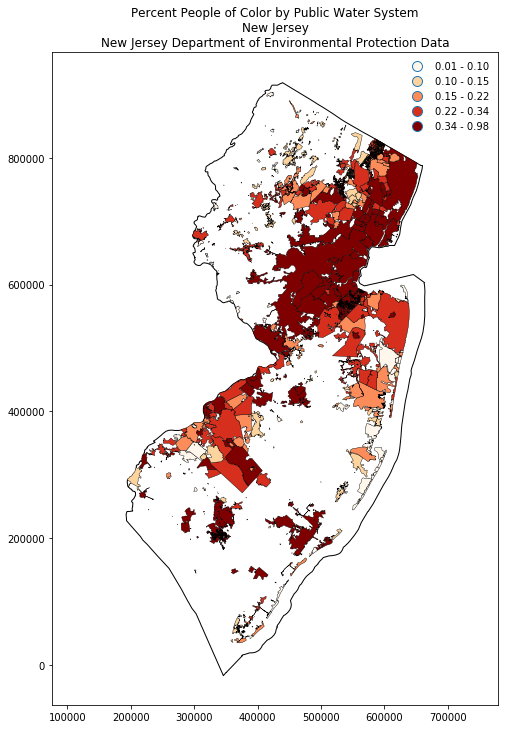

In [63]:
# Plotting percent people of color by public water system
# Plot the data
fig, ax = plt.subplots(figsize = (8,12))
NJ_boundary.plot(ax=ax,
                edgecolor='black',
                facecolor='white')
PWS_agg.plot(ax = ax,
             column='perc_POC', 
             scheme='QUANTILES',
             k=5,cmap='OrRd',
             edgecolor='black',
             linewidth=0.4, 
             legend=True)

# Geopandas source codes as the legend as a second axis
legend = ax.get_legend()
legend.get_frame().set_linewidth(0.0)
#legend.set(title = 'Percentage Below the Poverty Line')

# Add title to map
ax.set(title = "Percent People of Color by Public Water System\n" +
       "New Jersey\n"+
       "New Jersey Department of Environmental Protection Data")

# Turn off the axis
plt.axis('equal')
#ax.set_axis_off()